<a href="https://colab.research.google.com/github/rhehgus02/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C(5)_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<06> 평가**

* 머신러닝 프로세스: 데이터 가공/변환 -> 모델 학습/예측 -> 평가

* 성능 평가 지표는 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉨

* 회귀: 대부분 실제값과 예측값의 오차 평균값에 기반

* 분류: 일반적으로는 정확도에 기반, 이진 분류에서는 정확도보다는 다른 성능 평가 지표가 더 중요시됨
    * 정확도
    * 오차행렬
    * 정밀도
    * 재현율
    * F1 스코어
    * ROC AUC


---

## **1. 정확도**

* 정확도: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
    
    = (예측 결과가 동일한 데이터 건수) / (전체 예측 데이터 건수)

* 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표임

* 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 하나만 가지고 평가하지 않음

In [1]:
# 사이킷런의 BaseEstimator 클래스를 상속받아 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성
# BaseEstimator를 상속받으면 Customized 형태의 Estimator을 생성 가능

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

>> Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier을 만듦

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 타이타닉 데이터를 전처리하는 함수들을 다시 불러옴

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
# 앞 장의 타이타닉 생존자 예측 수행

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ESAA/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classfier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classfier의 정확도는: 0.7877


>> 이처럼 단순한 알고리즘으로 예측을 하더라도 정확도가 높은 수치가 나올 수 있으므로 정확도를 평가 지표로 사용할 때는 신중해야 함

* 특히 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 될 수 없음

* MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 시 어떤 문제가 발생하는지 살펴보기
    
    -> 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환 (불균형한 데이터 세트)


In [5]:
# 먼저 불균형한 데이터 세트와 Dummy Classifier를 생성

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool )

# 사이킷런의 내장 데이터 세트인 load_difits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

>> 7인지 아닌지에 따라 클래스 값을 True/False 이진 분류로 변경한 데이터 세트를 사용해 무조건 Negative로 예측하는 Classifier

In [6]:
# y_test의 데이터 분포도를 확인하고 MyFakeClassifier를 이용해 예측과 평가 수행

# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


>> 단순히 predict( )의 결과를 np.zeros( )로 모두 0값으로 반환함에도 불구하고 예측 정확도는 90%

>> 이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안 됨

---

## **2. 오차 행렬**

* 오차 행렬: 이진 분류의 예측 오류가 얼마인지 + 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타내는 지표

* 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지 나타냄

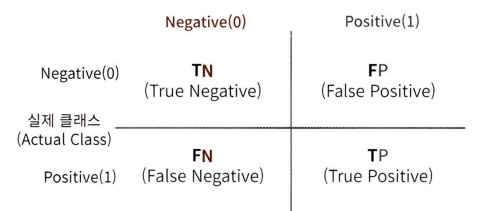

* TN, FP, FN, TP는 예측 클래스와 실제 클래스의 0값과 1값의 결합에 따라 결정
    * 앞 문자 T/F: 예측값과 실제값이 같은가(T)/다른가(F)
    * 뒤 문자 N/P: 예측 결과 값이 부정(N)/긍정(P)

* `confusion_matrix()`: 오차행렬을 구할 수 있는 사이킷런 API

In [7]:
# 예측 결과인 fakepred와 실제 결과인 y_test를 이용해 오차 행렬 구하기
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

>> TN 405건, FN 45건, FP 0건, TP 0건

* TN, FN, FP, TP를 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음

* 정확도: (TN + TP) / (TN + FP + FN + TP)

    -> 비대칭한 데이터 세트에서 Negative에 대한 예측 정확도만으로 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류가 생김
    
    ex) 10,000건의 데이터 세트에서 9,900건이 Negative이고 100건이 Positive라면 TN은 매우 커지고, TP, FN, FP는 매우 작아짐

---

## **3. 정밀도와 재현율**

* 정밀도(양성 예측도): 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

 = TP / (FP + TP) by `precision_score()`

* 재현율(민감도): 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

 = TP / (FN + TP) by `recall_score()`

* 재현율이 중요한 경우: 실제 Positive 데이터를 Negative로 잘못 판단하면 안 되는 경우(FN을 낮춤)
    
    ex) 암 판단 모델, 보험 사기 적발 모델

* 정밀도가 중요한 경우: 실제 Negative 음성인 데이터를 Positive로 잘못 판단하면 안 되는 경우(FP를 낮춤)

    ex) Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우 

* 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것

In [8]:
# confusion matrix, accuracy, precision, recall 등의 평가를 한번에 호출하는 함수 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [9]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고 평가를 수행
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ESAA/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---

### **3-1. 정밀도/재현율 트레이드오프**

* 트레이드오프: 정밀도 또는 재현율이 특별히 강조돼야 할 경우, 분류의 결정 임곗값을 조정해 하나의 수치를 높이는 것
    
    -> 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움

* `predict_proba()`: 개별 데이터별로 예측 확률을 반환하는 메서드

    * 학습이 완료된 Classifier 객체에서 호출 가능

    * 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환

    * 반환되는 각 열은 개별 클래스의 예측 확률
    
   -> 이진 분류에서 첫 번째 칼럼이 클래스 값 0에 대한 확률, 두 번째 칼럼이 클래스 값 1에 대한 확률

In [10]:
# 앞 예제의 LogisticRegression 객체에서 predict_proba()와 predict() 메서드 결과 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


>> `predict()`는 `predict_proba()` 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 예측 클래스를 결정

* `Binarizer` 클래스의 `fit_transform()` 사용하기

In [11]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

# 평가 지표 출력
get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


>> 이 의사 코드로 계산된 평가 지표는 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 `predict()`로 계산된 지표 값과 같음

>> `predict()`가 `predict_proba()`에 기반함을 알 수 있음

In [13]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


>> 재현율이 올라가고 정밀도가 떨어짐

>> 임계값을 낮추면 Positive 예측값이 많아지기 때문에 TP와 FP가 늘고 TN과 FN이 줄어듦

>> 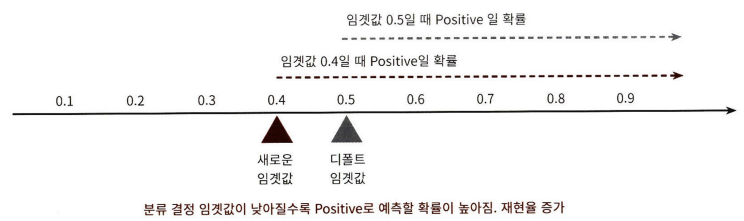

>> 재현율은 TP / (FN + TP)이므로 값이 높아짐

>> 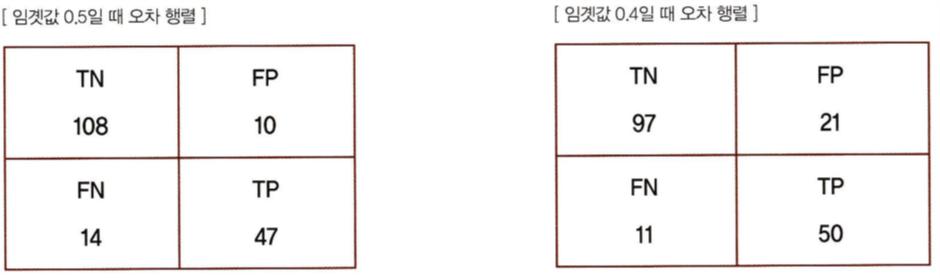

In [14]:
# get_eval_by_threshold() 함수 만들기

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print('')

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377



>> 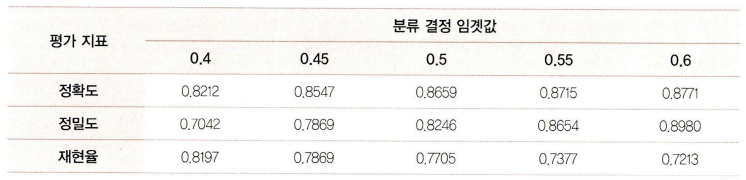

>> 재현율을 향상시키기 위해서는 임계값 0.45가 가장 적당해보임

* `precision_recall_curve()`: 0.11~0.95 정도의 임곗값별 정밀도와 재현율 반환

* 입력 파라미터:
    * `y_true`: 실제 클래스값 배열
    * `probas_pred`: Positive 칼럼의 예측 확률 배열

* 반환 값:
    * 정밀도: 입곗값별 정밀도 값
    * 재현율: 임곗값별 재현율 값

In [15]:
# precision_recall_curve()를 이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구하기
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임곗값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임곗값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임곗값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


>> 임곗값이 증가할수록 정밀도는 높아지지만 재현율은 낮아짐

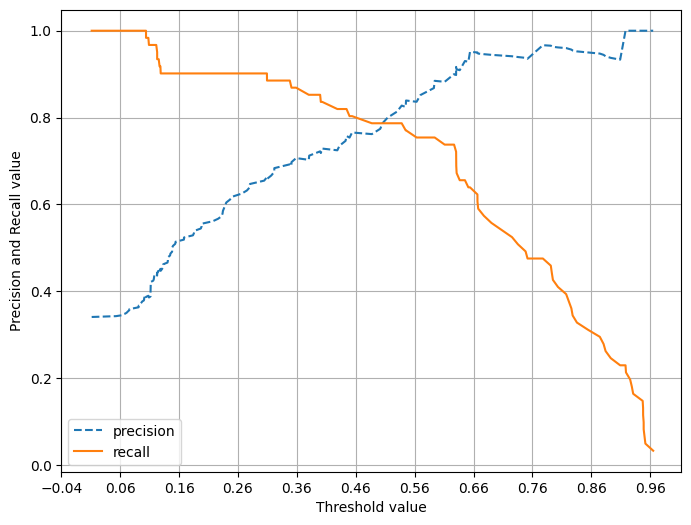

In [16]:
# 임곗값에 따른 정밀도와 재현율의 변화를 곡선 형태의 그래프로 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

>> 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐

---

### **3-2. 정밀도와 재현율의 맹점**

* 임곗값을 바꿈에 따라 정밀도와 재현율의 수치가 변경되지만 이러한 변경은 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 함

* 정밀도가 100%가 되는 방법: 정말 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측하는 것

 -> FP가 0이므로 TP / (TP + FP)가 1이 됨

* 재현율이 100%가 되는 방법: 모든 데이터를 Positive로 예측

 -> FN이 0이므로 TP / (TP + FN)이 1이 됨

---

## **4. F1 스코어**

* F1 스코어: 정밀도와 재현율을 결합한 지표

 -> 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

 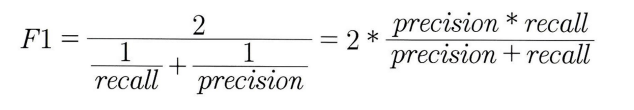

* `f1_score()`: 사이킷런의 F1 스코어를 구하는 API

In [17]:
# 로지스틱 회귀 기반 타이나틱 생존자 모댈의 F1 스코어 구하기
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [18]:
# 임곗값 0.4 ~ 0.6별로 정확도, 정밀도, 재현율, F1 스코어 구하기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036



>> 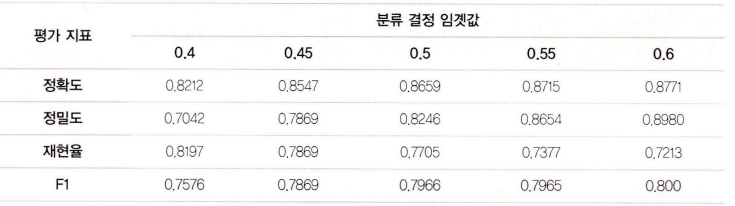

>> F1 스코어는 임곗값이 0.6일 때 가장 좋지만 이때 재현율이 크게 감소하고 있는 것을 알아야 함

---

## **5. ROC 곡선과 AUC**

* ROC 곡선: FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)가 어떻게 변하는지를 나타내는 곡선

 * FPR을 X축, TPR을 Y축으로 함
    
 * TPR = 재현율(민감도) = TP / (FN + TP)

 * TNR = 특이성 = TN / (FP  + TN)

 * FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성 

 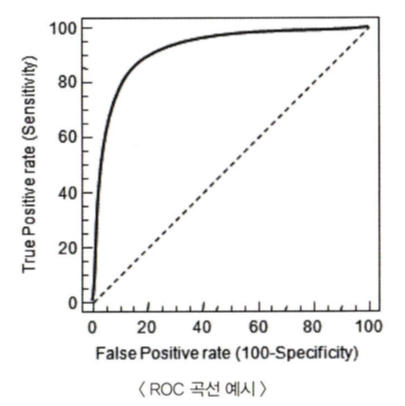

* 가운데 직선은 ROC 곡선의 최저값

* ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것

* FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구함
    * FPR을 0으로 만들려면 임곗값을 1로 지정
    * FPR을 1로 만들려면 임곗값을 0으로 지정



* `roc_curve()`: ROC 곡선을 구하는 API

* 입력 파라미터
    * `y_true`: 실제 클래스 값 array
    * `y_score`: 보통 predict_proba()의 반환 값에서 Positive 예측 확률

* 반환 값
    * fpr
    * tpr
    * thresholds

In [19]:
# roc_curve()를 이용해 FPR, TPR, 임곗값 구하기

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


>> 임곗값이 작아지면서 FPR은 점점 커짐

>> FPR이 조금씩 커질 때 TPR은 가파르게 커짐

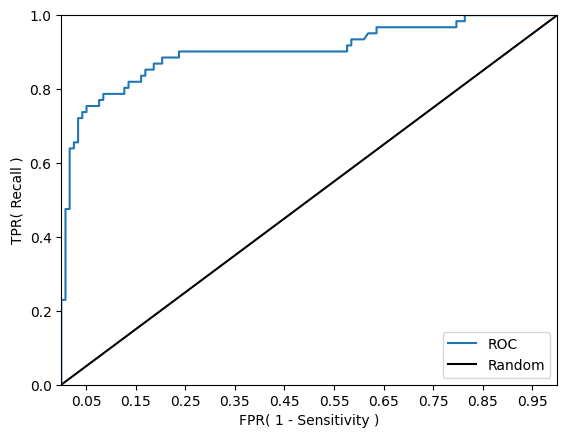

In [20]:
# FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0,1],[0,1],'k-', label='Random')

    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

* AUC: ROC 곡선 밑의 면적을 구한 것

  -> 1에 가까울수록 좋은 수치
  
  -> AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건

* 가운데 대각선 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5임

 -> 보통의 분류는 0.5 이상의 AUC 값을 가짐

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

#print(confusion_matrix(y_target, preds))
#print("정확도:", np.round(accuracy_score(y_target, preds), 4))
#print("정밀도:", np.round(precision_score(y_target, preds), 4))
#print("재현율:", np.round(recall_score(y_target, preds), 4))

In [23]:
# get_clf_eval() 함수에 ROC AUC 값을 측정하는 로직 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))